<a href="https://colab.research.google.com/github/STRMNGnwo/Final-Year-Project/blob/trained-half-dataset/FYP_UNETmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from google.colab import drive

#files.upload()

#g drive file path to total dataset /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/datasets
#g drive file path to split dataset /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Split_Patients
#g drive file path to split dataset /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/
drive.mount("/content/drive/") 


Mounted at /content/drive/


In [ ]:
!pip install torchmetrics
#importing the required modules to create the U-Net model
import torch, torchvision
from torch.nn import Module
from torch.nn import Conv2d #The convolutional layer used in the U-Net architecture
from torch.nn import ReLU #activation function
from torch.nn import BatchNorm1d, BatchNorm2d
from torch.nn import Sequential
from torch.nn import functional as f #to make the fully connected layer
from torch.nn import ConvTranspose2d
from torch.nn import MaxPool2d #max pooling layer that is implemented after Conv2d layers
from torchvision import transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tqdm

import os
import sys

sys.path.insert(0, '/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/')

#from CustomDataset import SegmentationCTADataset
from CustomDataset import CTADataset
#from split_patients import remove_DS_Store, split_patients, copy_collate_datasets

if torch.cuda.is_available():
  device=torch.device("cuda")
  torch.cuda.get_device_name(0)
  print("GPU")

else:
  device="cpu"
  print("CPU")



Importing the datasst data, which has been split into train,test and val sets by unzipping the prepared dataset file that is found in my google drive.

In [ ]:

#!unzip /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Prepared_Dataset.zip

!unzip /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Sample_Prepared_Dataset.zip

#unzip /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/SampleTrain.zip


Sliding Window CNNs involve dividing an input image into "patches" of pixels, passing each pixel into a CNN, and assigning a class label to the pixel. Their main benefit is that they can localize, and they can also result in more training data being available as a result of the patches being made. However they are very slow and computationally expensive.

Localization -> assigning a class label to a region of pixels on a pixel-by-pixel basis.

Trade-off between localization accuracy and the context available to the CNN-> exists due to varying patch sizes. Large Patch sizes allow for greater context, but lower localization accuracy and vice-versa.

The U-NET Architecture:

Consists of a contracting path that identifies context (descending/encoding) and a symmetrical expanding path that enables precise localization
of contours. U-NET is popular for medical image segmentation and is proven to be better than sliding window CNNs.

The Descending section:

The descending section of the architecture consists of convolutional layers that are followed by max-pooling layers . 
This pattern (Conv,Conv,Max-Pool) repeats. 
The input image is down-sampled (image size reduces but the number of channels increases).
After convolutions ->the number of channels seems to increase.
After max-pooling -> the image size decreases.

---------------------------
The Ascending section:

Consists of an expanding path, made up of convolutional layers and transposed convolutional layers(that upsample, ie increasing image size).
The Conv. layers in this section seem to reduce the number of channels


Notes from paper (3D UNET was used for segmentation): https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7817629/

The down-sampling path had a filter size of 3 × 3 × 32 and stride 2 in each convolution layer. 

All convolution layers were processed with batch normalization, Rectified Linear Units, and same-padding. T

In [4]:
#Building block of both Encoder section and Decoder section.
#At a high level: Encoder= Block +downsampling (max_pooling), Decoder= upsampling+ skip connection concatenation + Block
# Block -> Double Convolutional layers, with Batch Normalisation and ReLU activation functions between them.
class Block(Module):

    def __init__(self, in_channels,out_channels):
        
        super().__init__()

        self.conv=Sequential(
            #Conv1
            #in_channels,out_channels,filter_size(kernel),stride,padding(same padding=1), bias
            Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False), # bias is false because batch normalisation is used in the next step and it cancels out bias
            #NOTE: Would I need BatchNorm1D or BatchNorm2D?
            
            BatchNorm2d(out_channels),
            ReLU(inplace=True),

            #Conv2
            Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False), #bias=False because batch normalisation is used in the next step and it cancels out bias
            #NOTE: Would I need BatchNorm1D or BatchNorm2D?
            
            BatchNorm2d(out_channels),
            ReLU(inplace=True)
        )

    def forward(self,x):
        return self.conv(x)

In [5]:
#the descending section made of conv.layers and max-pool layers.
#The Encoder consists of multiple "blocks"  which consist of down-sampling and convolutional layers. 
#The Encoder reduces the spatial dimension and obtains information about the mask area/region of interest.
class Encoder(Module): 

    def  __init__(self,encoding_channels=(1,64,128,256,512)): #the channel values should probably be modified based on the paper.. 3 assumes rgb but images I have are grey scale

        super().__init__()

        self.channels=encoding_channels
        self.encoding_blocks=torch.nn.ModuleList()

        for i in range(0,len(self.channels)-1):
            in_channel=self.channels[i]
            out_channel=self.channels[i+1]
            self.encoding_blocks.append(Block(in_channel,out_channel))

        self.pool= MaxPool2d(kernel_size=2,stride=2) #reduces spatial dimensions by a factor of 2 each time it is called

    
    def forward(self,x):
        #intermediary results between blocks are stored here
        block_outputs=[]

        for block in self.encoding_blocks:
             
            #print("Data before pooling and before convolutions",x.shape)
            x=block(x) # the block's forward method is implicitly called.

            #print("Data before pooling and after convolutions",x.shape)

            #adding the block output to the list
            block_outputs.append(x) 

            #sending the output of the block to the max pooling layer
            x=self.pool(x)
            #print("Data after pooling",x.shape)

    #return the final form of the data and the intermediary results (skip-connections used in the Decoder section, in the U-NET architecture paper)        
        return [x,block_outputs] 


In [6]:
#The Decoder class has Decoder blocks to take in input data and skip connections, perform upsampling, concatenation of skip connection to data and Conv2D.
#The Decoder upsamples the localized information and provides context.
class Decoder(Module):
    
    def __init__(self,decoding_channels=(512,256,128,64,2)): #2 is the final one because of 2 classes-> TL and FL
        
        super().__init__()

        self.channels=decoding_channels
        self.decoding_blocks=torch.nn.ModuleList()
        
        #upsampling going to use transpose convolutional layers. Can also use bilinear + convolution
        self.upconvolutions=torch.nn.ModuleList()

        #making the up-sampling layers and the decoding blocks
        for i in range(0,len(decoding_channels)-1):
            in_channel=self.channels[i]
            out_channel=self.channels[i+1]
            self.decoding_blocks.append(Block(in_channel,out_channel))

            #NOTE due to the skip connections having to be added, would in_channel(first param below)  have to be *2
            self.upconvolutions.append(ConvTranspose2d(self.channels[i],self.channels[i+1],kernel_size=2,stride=2))

        
    def forward(self,x,encoder_intermediary_outputs):#encoder_intermediary_outputs are the list of skip connections from the encoder.
        
        #print("\n--------------Decoder------------------------")
        #print("Data in decoder")

        # for skipconnection in encoder_intermediary_outputs:
        #     print("Shape of skip connection: ",skipconnection.shape)
        
        for i in range (len(self.upconvolutions)):

            #print("Data shape before upsampling",x.shape)

            #using a transpose convolution to upsample the data (should )
            x=self.upconvolutions[i](x)

            #print("Data shape after upsampling",x.shape)
            
            #concatenating an intermediary output from encoder section to the data
            cropped_encoder_output=self.crop(encoder_intermediary_outputs[i],x)
            x=torch.cat([x,cropped_encoder_output],dim=1)

            #print("Data shape after concatenation with skip connection",x.shape)

            #sending the concatenated upsampled data through a decoding block
            x= self.decoding_blocks[i](x)
            #print("Data shape after upsampling, concatenation and convolution",x.shape)


        return x


    def crop(self, encoding_intermediary_output,x):
        
        #(_,_,H,W)=x.shape
        (_,_,H,W)=x.shape
        cropped_intermediary_output=torchvision.transforms.CenterCrop([H, W])(encoding_intermediary_output)

        return cropped_intermediary_output


        
        

            
        

In [7]:
class Bottleneck(Module):

  def __init__(self, in_channels=None, out_channels=None):

    super().__init__()
    self.in_channels=in_channels
    self.out_channels=out_channels

    #bottleneck_block=Block(in_channels=encoder_intermediaries[::-1],out_channels=(encoder_intermediaries[::-1]*2))
    self.block=Block(self.in_channels,self.out_channels)

  def forward(self,x):
    return self.block(x)

In [8]:
#Creating the U-NET class

#U-NET architecture:

""" 
Consists of a contracting path that identifies context (descending/encoding) and a symmetrical expanding path that enables precise localization
of contours. U-NET is popular for medical image segmentation and is proven to be better than sliding window CNNs.

Localization -> assigning a class label to a region of pixels on a pixel-by-pixel basis.
"""

class UNet(Module):

    def __init__(self,encoding_channels=(1,64,128),decoding_channels=(256,128,64),seg_classes=3, retainDim=True, outSize=(128, 128)): 
        
        #seg_classes is the number of classes that a pixel can belong to (2 being- TL and FL)
        #seg_classes is also the number of channels expected by the final conv layer which generates the map.

        #retainDim signifies if the original output dimension should be maintained or not when producing the map.

        super().__init__()

        #Encoder and Decoder are classes. Encoder is the descending section and the Decoder is the ascending of "U"
        self.encoder=Encoder(encoding_channels)
        self.bottleneck_block= Bottleneck(encoding_channels[-1],(encoding_channels[-1]*2) )
        self.decoder=Decoder(decoding_channels)

        self.retainDim=retainDim
        self.seg_classes=seg_classes
        self.outSize=outSize

        #defining the last single convolutional layer, which would output the segmentation map
        #in_channel,out_channel,kernel_size
        self.head=Conv2d(decoding_channels[-1],seg_classes,1)

    def forward(self,x):
        #data's entry point into the model

        #get intermediary output from encoder, as calling it implicity calls its forward method
        encoder_results=self.encoder(x)
        #obtain the skip connections
        encoder_intermediaries=encoder_results[1]
        #obtain the image that needs to be sent into the bottleneck block ("between the Descending and Ascending sections")
        final_data_from_encoder=encoder_results[0]


        #print("Encoder output shape:",final_data_from_encoder.shape)

        # the "bottleneck" layer-> layer between encoder and decoder, which has a double conv2d.

        #passing in the final image output from the encoder into the bottleneck block (does 2 Conv2D convolutions)
        bottleneck_output=self.bottleneck_block(final_data_from_encoder)

        #passing in the encoder output in reverse(latest output to oldest output) as the data to its forward function
        #and also passing in the encoder outputs to decoder
        
        #decoder_output=self.decoder(encoder_intermediaries[::-1][0],encoder_intermediaries[::-1][1:])


        #print("Bottleneck block output shape:",bottleneck_output.shape)

        decoder_output=self.decoder(bottleneck_output,encoder_intermediaries[::-1])

        map = self.head(decoder_output)
		
        if self.retainDim:
            map = torch.nn.functional.interpolate(map, self.outSize)
		
        #print("The type of the model output is :",type(map))
        #print("The shape of the segmentation map is: ",map.shape)
        
        # return the segmentation map
        return map





In [9]:
def visualiser(image):

    print(type(image))
    if(type(image)==torch.Tensor):
        print("tensor")
        transform=transforms.ToPILImage()
        display=transform(image)
        display.show()  

    elif(type(image)==Image.Image):
        print("image")
        image.show()

from numpy import ndarray
def visualiser_sample(image):
  print(type(image))

  if(type(image)==torch.Tensor):
    print("Image is in a tensor format")
    plt.imshow(image.permute(1, 2, 0))
    #plt.imshow(image)
    #plt.imshow((image* 255).astype(np.uint8))
    plt.show()

  if(type(image)==np.ndarray):
    print("Image is a numpy array")
    image=torch.from_numpy(image)
    plt.imshow(image)
    plt.imshow((image* 255).astype(np.uint8))
    plt.show()

def visualiser_colab(image):
  print(type(image))
  print("Image shape in visualiser_colab:",image.shape)

  if(type(image)==torch.Tensor):
    print("Image is in a tensor format")
    plt.imshow(image)
    plt.show()

  if(type(image)==np.ndarray):
    print("Image is a numpy array")
    image=torch.from_numpy(image)
    #plt.imshow(image.permute(1, 2, 0))
    plt.imshow(image)
    plt.show()
   

In [10]:
# from matplotlib import image
# from matplotlib import pyplot

# images=image.imread("/content/Prepared_Dataset/train/images/patient1-slice150.jpg")
# mask=image.imread("/content/Prepared_Dataset/train/masks/patient1-mask-slice150.jpg")

# pyplot.imshow(images)
# pyplot.show()
# pyplot.imshow(mask)
# pyplot.show()


In [ ]:
from matplotlib import image
from matplotlib import pyplot
train_path="/content/Prepared_Dataset/train"
val_path="/content/Prepared_Dataset/val"
test_path="/content/Prepared_Dataset/test"

sample_path="/content/SampleTrain"

#specifying transforms-> increasing contrast in the image and converting it to a Tensor
train_transforms=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
val_transforms=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
test_transforms=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])

#Setting up Custom Datasets and converting appropriate images to Tensors.

train_dataset= CTADataset(os.path.join(train_path,"images"),os.path.join(train_path,"masks"),transform=train_transforms)
val_dataset= CTADataset(os.path.join(val_path,"images"),os.path.join(val_path,"masks"),transform=val_transforms)
test_dataset=CTADataset(os.path.join(test_path,"images"),os.path.join(test_path,"masks"),transform=test_transforms)

#sample_dataset=CTADataset(os.path.join(sample_path,"images"),os.path.join(sample_path,"masks"),transform=train_transforms)

#getting a sample image and mask from an arbitrary patient and displaying it.
# target_map is the semantically segmented ground truth to be used in loss func
train_sampleimage,train_samplemask,imagePath,maskPath,target_map=train_dataset.__getitem__(980)

print("Sample image shape: ",train_sampleimage.shape)
# image_np= np.asarray(train_sampleimage)

# print(image_np.size)
print("Target map shape: ",target_map.shape)
print("Number of pixels in target map: ",target_map.size)


print("Length of sample dataset: ",train_dataset.__len__())
# visualiser_sample(train_sampleimage)
# visualiser_sample(train_samplemask)

pyplot.imshow(train_samplemask.permute(1,2,0))
pyplot.show()

#for pyplot to show image, it must be in format: width,height. target map-> channel, width, height
pyplot.imshow(np.squeeze(target_map)) #squeeze removes the channel dimension as its just 1

pyplot.show()

Creation of DataLoaders for the train, test and val datasets.

In [11]:
#making dataloaders for the train, test and val sets.

train_loader= DataLoader(train_dataset,batch_size=16,shuffle=False,drop_last=True)

val_loader= DataLoader(val_dataset,batch_size=32,shuffle=False,drop_last=True)
test_loader= DataLoader(test_dataset,batch_size=32,shuffle=False,drop_last=True)

# print(sample_dataset.__len__())

#sample_loader=DataLoader(sample_dataset,batch_size=16,shuffle=False)



Instantiating the UNET implementation model

Encoder:
Down-sample -> Max-pooling to reduce the size of the image.
Conv2D-> To increase the number of channels.

Decoder: 
Up-Sample -> To increase the image size
Conv2D-> To decrease the number of channles

In [12]:
#Instantiate the Block, Encoder,Decoder and UNET classes. Pass data into the UNET Class (model's data entrypoint)
print("The device being used is: ",device)

seg_map_height=128
seg_map_width=128

#encoding_channels=(3,64,128),decoding_channels=(256,128,64,2)
UNET_Model= UNet(encoding_channels=(3,64,128,256,512),decoding_channels=(1024,512,256,128,64),outSize=(seg_map_height,seg_map_width),seg_classes=3)
UNET_Model.to(device)

print("Encoder channels: ",UNET_Model.encoder.channels)
print("Decoder Channels: ", UNET_Model.decoder.channels)

# loss_func=torch.nn.BCEWithLogitsLoss()
# # train_sampleimage,train_samplemask=train_dataset.__getitem__(10)
# for (batch_index,(image,mask,imagePath,maskPath)) in enumerate(sample_loader):  
#   predictions=UNET_Model(image)
#   print("Image used: ",imagePath)
#   print("Mask used: ",maskPath)
#   print("Loss: ",loss_func(predictions,mask))

# #the torch.squeeze is done to remove the batch_size dimension from the image, which is usually 1 [batch_size,channels,height,width].

# print("The data type of the prediction is : ",type(predictions))
# predictions=torch.squeeze(predictions)
# visualiser_colab(predictions.detach().numpy())
# mask=torch.squeeze(mask)
# visualiser_colab(mask)


The device being used is:  cuda
Encoder channels:  (3, 64, 128, 256, 512)
Decoder Channels:  (1024, 512, 256, 128, 64)


In [13]:
'''accuracy score functions'''
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex

def calc_IOU_for_epoch(predictions_list, target_maps_list):
#predictions_list -> list of predictions in an epoch
#target_maps_list -> list of target_maps(ground-truth) in an epoch 
#predictions of shape -> [batch_size, channels(num of classes),width,height]
#target shape -> [batch_size,height,width] [height,width]= range(0,num_classes)

  mean_IOU_per_batch=[]
  IOU_Class0_per_batch=[] 
  IOU_Class1_per_batch=[] 
  IOU_Class2_per_batch=[] 

  for i in range(len(predictions_list)):
    prediction=predictions_list[i].cpu()
    target_map=target_maps_list[i].cpu()

    IOU_func= MulticlassJaccardIndex(num_classes=3,average="none")
    IOU_per_prediction= IOU_func(prediction,target_map)

    mean_IOU_per_batch.append(sum(IOU_per_prediction)/len(IOU_per_prediction))
    IOU_Class0_per_batch.append(IOU_per_prediction[0])
    IOU_Class1_per_batch.append(IOU_per_prediction[1])
    IOU_Class2_per_batch.append(IOU_per_prediction[2])

    #print("IOU per class shape:",IOU_per_prediction.shape)

    #print("IOU Score per class for this batch of predicted maps is : ",IOU_per_prediction[0], IOU_per_prediction[1], IOU_per_prediction[2])

  
  IOU_for_epoch=[]
  
  '''average mean IOU(IOU class1+IOU class2+IOU class3/num_classes) across epoch'''
  IOU_for_epoch.append(sum(mean_IOU_per_batch)/len(mean_IOU_per_batch))
  ''' average IOU for class 0 across epoch'''
  IOU_for_epoch.append(sum(IOU_Class0_per_batch)/len(IOU_Class0_per_batch))
  ''' average IOU for class 1 across epoch'''
  IOU_for_epoch.append(sum(IOU_Class1_per_batch)/len(IOU_Class1_per_batch))
  ''' average IOU for class 2 across epoch'''
  IOU_for_epoch.append(sum(IOU_Class2_per_batch)/len(IOU_Class2_per_batch))


  return IOU_for_epoch
  #IOU_per epoch is a list:
  #[mean_IOU_across_predictions,mean_IOU_class1_across_predictions, ..classn_across_predictions]

  '''
  IDEA:
  IOU_per_batch:
  going to be a list, where each index is a list of tuple IOU for a batch in the epoch.

  IOU_per_batch[index]= [(mean IOU across classes),(IOU class1, IOU class2,..)]
   '''



Defining the model's hyper-parameters:

In [14]:
#defining and initialising model hyper-parameters

initial_learning_rate=0.0001

#Optimizer function -> Adam
optimizer_function= torch.optim.Adam(params=UNET_Model.parameters(),lr=initial_learning_rate)

batch_size=16

num_epochs=10

training_loss_list=[]

#loss_func= binary_cross_entropy
#loss_function=torch.nn.BCEWithLogitsLoss()

#loss_func= cross_entropy (as its a 3 class pixel classification problem)

'''
for CrossEntropyLoss to work, expected mask/target should be either 
Class indices in the range [0,C) where C is the number of classes or
Probabilities for each class
'''

#What I think is happening: 
'''
Mask data does not contain classes assigned to pixels. It is simply rgb pixel values.

image and mask values have been normalized from (0 to 255) to (0,1)
so what if CrossEntropyLoss is assuming them to be probability values and as all the values are between
0 and 1 (like 0.2, 0.3, 0.5) it is flooring them to be class 0?.

'''

loss_function=torch.nn.CrossEntropyLoss()



Training the model on the training samples. 
Calculating loss/error using the loss function. 
Backpropagating the error through the model, to readjust weights.

In [15]:
IOU_per_epoch=[]

#Training

#epoch -> entire run of a CNN through an entire training dataset.
#enumeration of a data loader-> passing batches of data to train the model, backpropogate error and optimise weights

for i in range(num_epochs):
  #setting the model mode to train
  UNET_Model.train()
  #images_path_list=[]
  #masks_path_list=[]

  images_list=[]
  masks_list=[]
  
  predictions_list=[]
  target_maps_list=[]

  #looping through batches of data made by the training DataLoader.
  for (batch_index,(image,mask,imagePath,maskPath,target_map)) in tqdm.tqdm(enumerate(train_loader),total=len(train_loader)):
    
    #switching the data over to the GPU
    image=image.to(device)
    #somehow target_map becomes a tensor from a np array. values still remain the same (0,1,2)
    #shape of target-> batch, 1(channel), width, height

    target_map= torch.squeeze(target_map) #removing the 1 channel this is because CELoss expects form->[N, H, W]
    target_map=target_map.to(dtype=torch.long)
    target_map=target_map.to(device) 

    
    #adding images and masks in this list to batch
    images_list.append(image)
    masks_list.append(mask)
    target_maps_list.append(target_map)

    #making the prediction for the input image
    predictions=UNET_Model(image)
    
    # moving predictions to cpu and appending it to list, to see if it prevents CUDA out of memory.
    predictions_list.append(predictions.cpu())

    #predictions_list.append(predictions)

    #Calculating loss
    
    loss=loss_function(predictions,target_map)
    training_loss_list.append(loss.item())

    #zeroing out accumulated gradients as weights have already been modified according to them during the previous run.
    optimizer_function.zero_grad()

    #Back propogation:
    loss.backward()

    #updating weights
    optimizer_function.step()
  '''calculate IOU per epoch'''
    

  #end of epoch loop
  IOU_per_epoch.append(calc_IOU_for_epoch(predictions_list,target_maps_list))

  print(f"----------------------After epoch {i}------------------------------------------")
  print(f"At end of epoch {i}, the mean IOU across 3 classes is: ",IOU_per_epoch[i][0])
  print(f"At end of epoch {i}, the mean IOU for class 0(Background) is: ",IOU_per_epoch[i][1] )
  print(f"At end of epoch {i}, the mean IOU for class 1(TL) is: ",IOU_per_epoch[i][2] )
  print(f"At end of epoch {i}, the mean IOU for class 2(FL) is: ",IOU_per_epoch[i][3] )



print("Ended training phase")
print("Training losses are as follows: ",training_loss_list)

##NOTE: Images are represented during training in the format: [batchsize,channels,height,width]

#displaying the predicted mask and the actual mask
print("The data type of the prediction is : ",type(predictions))



100%|██████████| 768/768 [11:27<00:00,  1.12it/s]


----------------------After epoch 0------------------------------------------
At end of epoch 0, the mean IOU across 3 classes is:  tensor(0.3272)
At end of epoch 0, the mean IOU for class 0(Background) is:  tensor(0.9816)
At end of epoch 0, the mean IOU for class 1(TL) is:  tensor(3.1311e-06)
At end of epoch 0, the mean IOU for class 2(FL) is:  tensor(6.7707e-05)


100%|██████████| 768/768 [11:19<00:00,  1.13it/s]


----------------------After epoch 1------------------------------------------
At end of epoch 1, the mean IOU across 3 classes is:  tensor(0.3432)
At end of epoch 1, the mean IOU for class 0(Background) is:  tensor(0.9931)
At end of epoch 1, the mean IOU for class 1(TL) is:  tensor(0.0076)
At end of epoch 1, the mean IOU for class 2(FL) is:  tensor(0.0290)


100%|██████████| 768/768 [11:19<00:00,  1.13it/s]


----------------------After epoch 2------------------------------------------
At end of epoch 2, the mean IOU across 3 classes is:  tensor(0.3992)
At end of epoch 2, the mean IOU for class 0(Background) is:  tensor(0.9953)
At end of epoch 2, the mean IOU for class 1(TL) is:  tensor(0.)
At end of epoch 2, the mean IOU for class 2(FL) is:  tensor(0.2025)


100%|██████████| 768/768 [11:18<00:00,  1.13it/s]


----------------------After epoch 3------------------------------------------
At end of epoch 3, the mean IOU across 3 classes is:  tensor(0.4970)
At end of epoch 3, the mean IOU for class 0(Background) is:  tensor(0.9970)
At end of epoch 3, the mean IOU for class 1(TL) is:  tensor(0.1436)
At end of epoch 3, the mean IOU for class 2(FL) is:  tensor(0.3503)


100%|██████████| 768/768 [11:18<00:00,  1.13it/s]


----------------------After epoch 4------------------------------------------
At end of epoch 4, the mean IOU across 3 classes is:  tensor(0.5720)
At end of epoch 4, the mean IOU for class 0(Background) is:  tensor(0.9977)
At end of epoch 4, the mean IOU for class 1(TL) is:  tensor(0.2960)
At end of epoch 4, the mean IOU for class 2(FL) is:  tensor(0.4222)


100%|██████████| 768/768 [11:20<00:00,  1.13it/s]


----------------------After epoch 5------------------------------------------
At end of epoch 5, the mean IOU across 3 classes is:  tensor(0.5996)
At end of epoch 5, the mean IOU for class 0(Background) is:  tensor(0.9980)
At end of epoch 5, the mean IOU for class 1(TL) is:  tensor(0.3448)
At end of epoch 5, the mean IOU for class 2(FL) is:  tensor(0.4560)


100%|██████████| 768/768 [11:20<00:00,  1.13it/s]


----------------------After epoch 6------------------------------------------
At end of epoch 6, the mean IOU across 3 classes is:  tensor(0.6229)
At end of epoch 6, the mean IOU for class 0(Background) is:  tensor(0.9985)
At end of epoch 6, the mean IOU for class 1(TL) is:  tensor(0.3687)
At end of epoch 6, the mean IOU for class 2(FL) is:  tensor(0.5014)


100%|██████████| 768/768 [11:20<00:00,  1.13it/s]


----------------------After epoch 7------------------------------------------
At end of epoch 7, the mean IOU across 3 classes is:  tensor(0.6422)
At end of epoch 7, the mean IOU for class 0(Background) is:  tensor(0.9986)
At end of epoch 7, the mean IOU for class 1(TL) is:  tensor(0.4065)
At end of epoch 7, the mean IOU for class 2(FL) is:  tensor(0.5214)


100%|██████████| 768/768 [11:24<00:00,  1.12it/s]


----------------------After epoch 8------------------------------------------
At end of epoch 8, the mean IOU across 3 classes is:  tensor(0.6600)
At end of epoch 8, the mean IOU for class 0(Background) is:  tensor(0.9987)
At end of epoch 8, the mean IOU for class 1(TL) is:  tensor(0.4398)
At end of epoch 8, the mean IOU for class 2(FL) is:  tensor(0.5416)


100%|██████████| 768/768 [11:26<00:00,  1.12it/s]


----------------------After epoch 9------------------------------------------
At end of epoch 9, the mean IOU across 3 classes is:  tensor(0.6743)
At end of epoch 9, the mean IOU for class 0(Background) is:  tensor(0.9989)
At end of epoch 9, the mean IOU for class 1(TL) is:  tensor(0.4621)
At end of epoch 9, the mean IOU for class 2(FL) is:  tensor(0.5620)
Ended training phase
Training losses are as follows:  [1.220569133758545, 1.1523562669754028, 1.1092157363891602, 1.081303358078003, 1.0528230667114258, 1.0282063484191895, 1.0142827033996582, 0.998153805732727, 0.9617721438407898, 0.9408608078956604, 0.9190706014633179, 0.9640066623687744, 1.0372637510299683, 1.0011719465255737, 0.9742993116378784, 0.9577254056930542, 0.9444923996925354, 0.9309300184249878, 0.9174575209617615, 0.904741108417511, 0.8847991228103638, 0.8660200834274292, 0.8488668203353882, 0.835684061050415, 0.8195882439613342, 0.8025987148284912, 0.7885385155677795, 0.7713696956634521, 0.7549181580543518, 0.740727961

Predictions stored:  768
Predictions(from model) shape: torch.Size([16, 3, 128, 128])
Images stored 768
Masks stored 768
Target maps stored 768
Shape of the Image from list :  torch.Size([16, 3, 128, 128])
Shape of the expected mask from list:  torch.Size([16, 3, 128, 128])
Shape of the predictions from list:  torch.Size([16, 3, 128, 128])
Shape of the target_maps from list:  torch.Size([16, 128, 128])
Input image


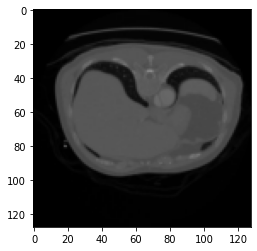

Expected mask


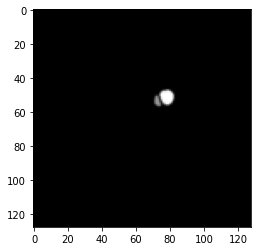

Ground truth target mask passed into loss func:
<class 'torch.Tensor'>
Image shape in visualiser_colab: torch.Size([128, 128])
Image is in a tensor format


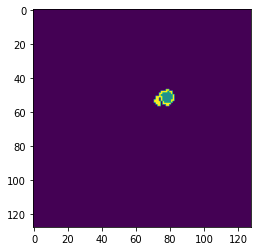

The Model output mask
Prediction type from list :  <class 'torch.Tensor'>
predictions shape before being displayed:  torch.Size([3, 128, 128])
Predictions shape after permuting it: torch.Size([128, 128, 3])
<class 'numpy.ndarray'>
Image shape in visualiser_colab: (128, 128, 3)
Image is a numpy array


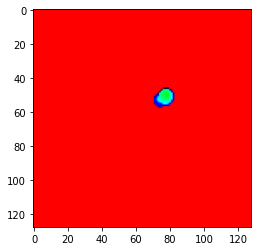

Predictions values tensor([-7.0172, -6.7802, -5.9683,  ...,  5.5525,  5.9144,  6.0311],
       grad_fn=<Unique2Backward0>)
Target_map unique values:  tensor([0, 1, 2])


In [28]:
#array[0][:][:][:]
#print("Image paths stored",len(images_path_list))
#print("Mask paths stored",len(masks_path_list))

print("Predictions stored: ",len(predictions_list))
print("Predictions(from model) shape:",predictions.shape)

print("Images stored",len(images_list))
print("Masks stored",len(masks_list))
print("Target maps stored", len(target_maps_list))

#getting a certain index of predictions,images and masks.
list_index=675
image=images_list[list_index]
mask= masks_list[list_index]
predictions=predictions_list[list_index]
target_map=target_maps_list[list_index]

#to convert tensor to numpy array to plot, switch it from gpu to cpu
mask=mask.cpu()
predictions=predictions.cpu()
image=image.cpu()
target_map=target_map.cpu()

print("Shape of the Image from list : ", image.shape)
print("Shape of the expected mask from list: ", mask.shape)
print("Shape of the predictions from list: ", predictions.shape)
print("Shape of the target_maps from list: ",target_map.shape)
# print("Image used: ",images_path_list[list_index])
# print("Mask used: ",masks_path_list[list_index])


batch=batch_size-1

#taking a single image from the batch of images, 
#permuting it to display it and then displaying the input image using pyplot's imshow function.
print("Input image")
image=image[batch][:][:][:]
image=image.permute(1,2,0)
plt.imshow(image.detach().numpy())
plt.show()

#reading in mask 1, from the batch of 32. 
#Also permuting it, so shape becomes [height,width,channel]
print("Expected mask")
mask=mask[batch][:][:][:]
mask=mask.permute(1,2,0)
plt.imshow(mask.detach().numpy())
plt.show()


print("Ground truth target mask passed into loss func:")
individual_target_map=target_map[batch][:][:]
visualiser_colab(individual_target_map)
print("The Model output mask")

print("Prediction type from list : ",type(predictions))

#reading in prediction 1, from the batch of 32
#also permuting it so shape becomes [height,width,channel]
individual_prediction=predictions[batch][:][:][:]
print("predictions shape before being displayed: ",individual_prediction.shape)
individual_prediction=individual_prediction.permute(1,2,0) #shape becomes 128,128,3
print("Predictions shape after permuting it:",individual_prediction.shape)
# predictions=transf(predictions)
visualiser_colab(individual_prediction.detach().numpy())


print("Predictions values", torch.unique(individual_prediction))

print("Target_map unique values: ",torch.unique(individual_target_map))


In [ ]:
#SAVING THE MODEL
path="/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/saved_model-fulldataset-4epoch"
torch.save(UNET_Model,path)

In [36]:
#loading in "trained" model
model=torch.load("/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/saved_model-fulldataset-4epoch")

'''
val_image, val_mask,img_path,mask_path,val_target_map=val_dataset.__getitem__(910)

plt.imshow(val_image.permute(1,2,0))
plt.show()

plt.imshow(val_mask.permute(1,2,0))
plt.show()

plt.imshow(np.squeeze(val_target_map))
plt.show()

resizer= torchvision.transforms.Resize(size=(128,128))
val_image=resizer(val_image)
val_image = val_image[None,:, :]
print("val image shape after adding channel dimension", val_image.shape)

#prediction being made
val_image=val_image.to(device)
val_prediction=model(val_image)
val_prediction=val_prediction.cpu()
print(val_prediction.shape)

val_prediction=torch.squeeze(val_prediction)
val_prediction=val_prediction.permute(1,2,0)
plt.imshow(val_prediction.detach().numpy())
plt.show()
'''

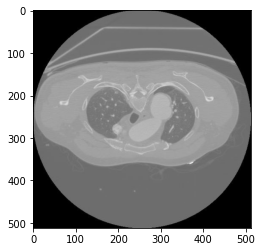

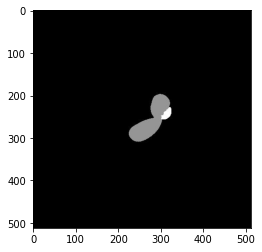

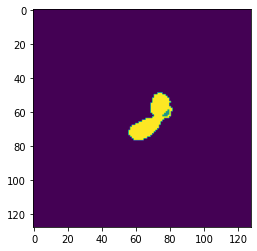

val image shape after adding channel dimension torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


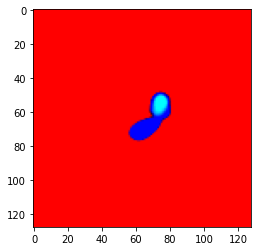

In [ ]:
# testing model on validation set:
images_list=[]
masks_list=[]
images_path_list=[]
masks_path_list=[]
predictions_list=[]
target_maps_list=[]

for (batch_index,(image,mask,imagePath,maskPath,target_map)) in tqdm.tqdm(enumerate(val_loader),total=len(val_loader)):
    
    #switching the data over to the GPU
    image=image.to(device)
    #somehow target_map becomes a tensor from a np array. values still remain the same (0,1,2)
    #shape of target-> batch, 1(channel), width, height

    target_map= torch.squeeze(target_map) #removing the 1 channel this is because CELoss expects form->[N, H, W]
    #print("target_map dimension",target_map.shape)
    target_map=target_map.to(dtype=torch.long)
    target_map=target_map.to(device) 

    if i==num_epochs-1:
      #adding images and masks in this list to batch
      images_list.append(image)
      masks_list.append(mask)
      images_path_list.append(imagePath)
      masks_path_list.append(maskPath)
      target_maps_list.append(target_map)

      predictions=model(image)
      predictions_list.append(predictions)


In [32]:
# Accuracy Metrics functions below


'''both predictions and target are a single batch of seg maps and a single batch of target maps.
as a result of the displaying code in the above section. Will do metrics on
a single batch of images first, and then do it across a list.
'''
print(predictions.shape)
print(target_map.shape)
#accuracy metric functions
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex
from torchmetrics import Dice

'''function to calculate overall IOU (Intersection over union) AKA Jaccard index:'''

#would I need to calculate IOU on a per class basis between ground truth 
# and the prediction mask?-> probably

# IOU =INTERSECTING pixels between pred and GT / Union  where union= (TP/FP+FN+TP)

'''function to calculate IOU (Jaccard Index) per class:'''

IOU_func= MulticlassJaccardIndex(num_classes=3,average="none")

IOU_per_batch= IOU_func(predictions,target_map)
print("IOU per class shape:",IOU_per_batch.shape)

print("IOU Score per class for this batch of predicted maps is : ",IOU_per_batch[0], IOU_per_batch[1], IOU_per_batch[2])


#calculating dice score of prediction
# Dice coeff= 2*Intersection / Intersection + union (union-> pred pixels)

'''function to calculate dice score:

NOTE: Potential issue where dice required preds and target to have same shape.
'''

#dice_func= Dice(num_classes=3,average="none")






torch.Size([16, 3, 128, 128])
torch.Size([16, 128, 128])
IOU per class shape: torch.Size([3])
IOU Score per class for this predicted map is :  tensor(0.9952) tensor(0.) tensor(0.5382)
IOU Score for this predicted map is :  tensor(0.5111)


ValueError: ignored